# Model 2

In this model I just use linear regression to show the relationship between temperature and various types of calls. Some types of calls are very sensitive to outdoor temperature, others are not.

In [1]:
import pandas as pd
import numpy as np
import operator

import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

#df_joined = pd.read_csv("~/Projects/CourseraCapstone/joined.csv")

In [2]:
df_weather = pd.read_csv("csvs/Weather_One_Shot.csv", usecols=[1,4,6,7,8,9])
df_weather['Date Only'] = df_weather['DATE'].apply(lambda x: x[0:10])
df_weather['SeqNum'] = df_weather.index


df_ten = pd.read_csv("csvs/grouped_top_ten.csv", usecols=[0,1,2])
df_ten.rename(index=str, columns={"Unique Key": "Count"}, inplace=True)
df_weather.head(10)

,DATE,DailyAverageDryBulbTemperature,DailyPrecipitation,DailySnowDepth,DailySnowfall,wind2,Date Only,SeqNum
0,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,2015-01-01,0
1,2015-01-02 23:59:00,39,0.00,0.0,0.0,25.0,2015-01-02,1
2,2015-01-03 23:59:00,38,0.71,0.0,0.0,18.0,2015-01-03,2
3,2015-01-04 23:59:00,49,0.30,0.0,0.0,46.0,2015-01-04,3
4,2015-01-05 23:59:00,35,0.00,0.0,0.0,38.0,2015-01-05,4
5,2015-01-06 23:59:00,21,0.05,0.0,1.0,24.0,2015-01-06,5
6,2015-01-07 23:59:00,16,0.00,1.0,0.0,39.0,2015-01-07,6
7,2015-01-08 23:59:00,15,0.00,0.0,0.0,31.0,2015-01-08,7
8,2015-01-09 23:59:00,26,0.07,0.0,1.5,30.0,2015-01-09,8
9,2015-01-10 23:59:00,20,0.00,1.0,0.0,25.0,2015-01-10,9


In [3]:
df_joined = pd.merge(df_ten, df_weather)
df_joined['Complaint ID'] = df_joined['Complaint Type']
df_joined['Complaint ID'] = df_joined['Complaint ID'].map({'Blocked Driveway': 1,'HEAT/HOT WATER': 2,'Illegal Parking': 3,'Noise - Residential': 4,'Noise - Street/Sidewalk': 5,'Street Condition': 6,'Street Light Condition': 7,'UNSANITARY CONDITION': 8,'Water System': 9,'Request Large Bulky Item Collection': 10})

df_joined['dow'] = pd.to_datetime(df_joined['DATE']).dt.dayofweek

df_joined.head(40)

,Date Only,Complaint Type,Count,DATE,DailyAverageDryBulbTemperature,DailyPrecipitation,DailySnowDepth,DailySnowfall,wind2,SeqNum,Complaint ID,dow
0,2015-01-01,Blocked Driveway,288,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,1,3
1,2015-01-01,HEAT/HOT WATER,1163,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,2,3
2,2015-01-01,Illegal Parking,114,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,3,3
3,2015-01-01,Noise - Residential,985,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,4,3
4,2015-01-01,Noise - Street/Sidewalk,40,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,5,3
5,2015-01-01,Street Condition,109,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,6,3
6,2015-01-01,Street Light Condition,48,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,7,3
7,2015-01-01,UNSANITARY CONDITION,100,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,8,3
8,2015-01-01,Water System,68,2015-01-01 23:59:00,33,0.00,0.0,0.0,31.0,0,9,3
9,2015-01-02,Blocked Driveway,223,2015-01-02 23:59:00,39,0.00,0.0,0.0,25.0,1,1,4


In [4]:
df_joined.mean()

Count                             344.204341
DailyAverageDryBulbTemperature     55.641854
DailyPrecipitation                  0.133990
DailySnowDepth                      0.435249
DailySnowfall                       0.108056
wind2                              19.673946
SeqNum                            819.300553
Complaint ID                        5.209069
dow                                 3.001798
dtype: float64

## Plotting functions

These are some simple plotting functions to show call type vs weather. I've implemented straight linear regression as well as polynomial regression.

In [5]:
def linear(feature):
    a = df_joined['Complaint Type']==feature

    m = pd.DataFrame()
    m['Temperature'] = df_joined['DailyAverageDryBulbTemperature'][a]
    m['Number of Calls'] = df_joined['Count'][a]

    m2 = pd.DataFrame(m.groupby('Temperature').mean())
    m2.reset_index(inplace=True)
    
    X = np.asarray(m2['Temperature'])
    y = np.asarray(m2['Number of Calls'])
 

    X = X[:, np.newaxis]
    y = y[:, np.newaxis]


    model = LinearRegression()
    reg = model.fit(X, y)
    y_pred = model.predict(X)

    #print('reg.score(X, y) =',reg.score(X, y))
    #print('reg.coef_ =',reg.coef_)
    #print('reg.intercept_ =',reg.intercept_ )
    #print('predict =',reg.predict(X))

    rmse = np.sqrt(mean_squared_error(y,y_pred))
    r2 = r2_score(y,y_pred)
    print("RSME = ",rmse, " r2 = ",r2)


    plt.scatter(X, y, s=10)
    plt.plot(X, y_pred, color='r')
    plt.show()
    
#linear('HEAT/HOT WATER')    

In [49]:
def poly2(feature, degree=2, we=0):
    a = df_joined['Complaint Type']==feature
    
    if (we == 1): #weekday
        a = (df_joined['dow'].isin([0,1,2,3,4])) & a 
    if (we == 2): #weekend
        a = df_joined['dow'].isin([5,6]) & a

#    print (a.head())        

    m = pd.DataFrame()
    m['Temperature'] = df_joined['DailyAverageDryBulbTemperature'][a]
    m['Number of Calls'] = df_joined['Count'][a]

    m2 = pd.DataFrame(m.groupby('Temperature').mean())
    m2.reset_index(inplace=True)

    X = np.asarray(m2['Temperature'])
    y = np.asarray(m2['Number of Calls'])

    X = X[:, np.newaxis]
    y = y[:, np.newaxis]

    polynomial_features= PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(X)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    print("RSME = ",rmse, " r2 = ",r2)


    plt.scatter(X, y, s=10)
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X,y_poly_pred), key=sort_axis)
    X, y_poly_pred = zip(*sorted_zip)
    plt.plot(X, y_poly_pred, color='m')
    plt.show()

#poly2('HEAT/HOT WATER')

## Heat/Hot Water

Heat/Hot Water tracks temperature fairly well with a 5th degree polynomial

RSME =  273.00829353259303  r2 =  0.9626955642066164


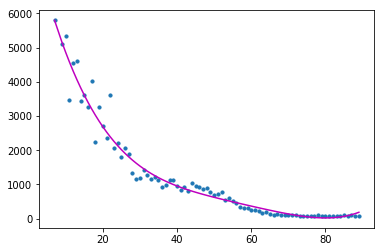

In [7]:
poly2('HEAT/HOT WATER', 5)

## Noise - Street/Sidewalk 

Noise - Street/Sidewalk is related to temperature. There's an interesting effect on warm weekends vs weekdays. It looks like the plot bifurcates. This could be an interesting refinement in the next study.

RSME =  28.93481093789786  r2 =  0.9343309968672082


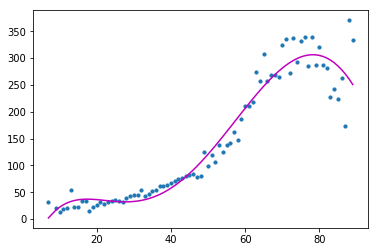

In [50]:
poly2('Noise - Street/Sidewalk',5)

## Noise - Street/Sidewalk Weekdays

Noise - Street/Sidewalk Weekdays is very strongly related to temperature. There's an interesting effect on warm weekends vs weekdays. It looks like the plot bifurcates. This could be an interesting refinement in the next study.

RSME =  15.686350903988311  r2 =  0.9624427012727925


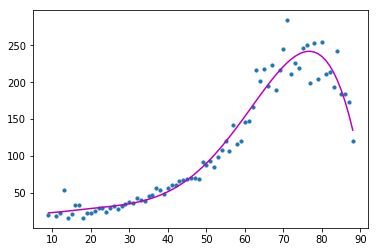

In [51]:
poly2('Noise - Street/Sidewalk',5, 1)

## Noise - Street/Sidewalk Weekends

Noise - Street/Sidewalk Weekends is very strongly related to temperature. There's an interesting effect on warm weekends vs weekdays. It looks like the plot bifurcates. This could be an interesting refinement in the next study.

RSME =  37.995806915552215  r2 =  0.9590672697592635


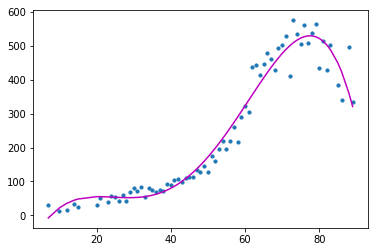

In [52]:
poly2('Noise - Street/Sidewalk',5, 2)

## Water System 

Water System is strongly related to temperature. Pipes freeze below a certain temperature, and people open fire hydrants when the weather gets warm resulting in low pressure.

RSME =  65.18476201939013  r2 =  0.8112357259646641


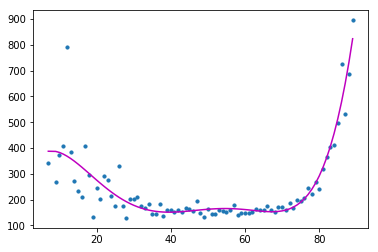

In [9]:
poly2('Water System',5)

## Illegal Parking

Illegal Parking seems to increase as temperatures improve, but with an R2 score of .48 they are not a great predictor of weather.

RSME =  44.64612011946059  r2 =  0.47999406147244306


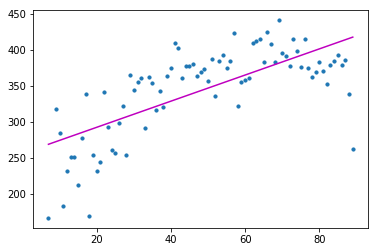

In [10]:
poly2('Illegal Parking',1)

## Street Condition

Street Condition complaints seem to peak as the temperature moves from freezing to warmer weather. But the data is widely spread out. It seems to converge more with the regression at higher temperatures.

RSME =  49.89688273782188  r2 =  0.38475165239041964


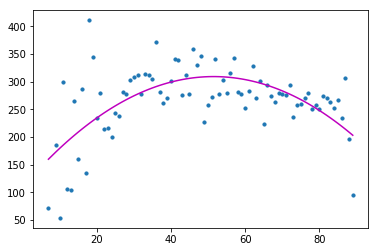

In [11]:
poly2('Street Condition')

## Unsanitary Conditions 

Unsanitary Conditions feels like it should be related to temperature. Why are there more complaints in the winter than in moderate cold? You might expect conditions to worsen as temperatures rise, and they do, but numbers of complaints are widely scattered. Not a good predictor of temperature.

RSME =  31.357817632161225  r2 =  0.23053853979509364


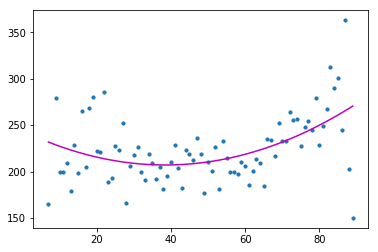

In [12]:
poly2('UNSANITARY CONDITION',2)

## Street Light Condition

Street Light Condition is not a great preditor of temperature, and is fairly consistent within its range.

RSME =  56.804691129098224  r2 =  0.13748275138911403


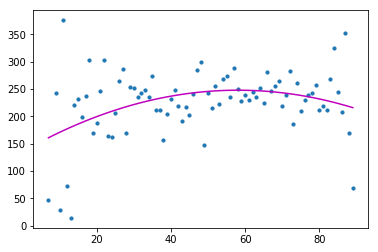

In [13]:
poly2('Street Light Condition')

## Blocked Driveway

Blocked Driveway complaints are fairly flat with respect to temperature, and stay in a fairly consistent range when the weather is above freezing.

RSME =  29.88998396118131  r2 =  0.09954234191402134


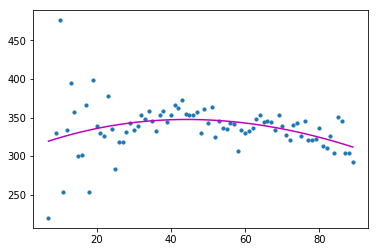

In [14]:
poly2('Blocked Driveway',3)

## Noise - Residential 

Noise - Residential is not closely related to temperature, although it trends upwards slightly as temperature increases. Regression provides a poor fit.

RSME =  119.47376563155588  r2 =  0.07937699376101581


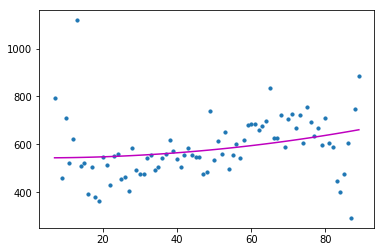

In [15]:
poly2('Noise - Residential')